<h1 style="font-family:Impact,Arial;font-size:30px;">37004 Interest Rates and Credit Risk Models - Spring 2024</h1>
<h1 style="font-family:Impact,Arial;font-size:45px;">Assignment Part 2</h1>
<h2 style="font-family:Arial;">Erik Schl&ouml;gl</h2>
<p><small> School of Mathematical &amp; Physical Sciences<br>
University of Technology Sydney
</small></p>
<p>
<a href="mailto:Erik.Schlogl@uts.edu.au?Subject=37000 JIT" target="_blank">
<small><font color=MediumVioletRed>Erik.Schlogl@uts.edu.au</font></small></a>
</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />


Consider the data files <code>daily-treasury-rates2018.csv</code>, <code>daily-treasury-rates2019.csv</code>, <code>daily-treasury-rates2020.csv</code>, <code>daily-treasury-rates2021.csv</code> and <code>daily-treasury-rates2022.csv</code>. They contain the United States Treasury's "Daily Yield Curve" data (sourced from www.treasury.gov) for the years 2018 to 2022. These rates are what the US Treasury calls "CMT rates" (see
https://www.treasury.gov/resource-center/faqs/Interest-Rates/Pages/faq.aspx).


# Import package


In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve as solver
from scipy.stats import norm
from scipy.integrate import quad as integrator
from matplotlib import pyplot as plt

<H2>Task 1:</H2>
Convert these rates into continuously compounded yields. <I>(1 mark)</I>


In [2]:
df = pd.DataFrame({})
for year in [2018, 2019, 2020, 2021, 2022]:
    df = pd.concat(
        [df, pd.read_csv(f"daily-treasury-rates{year}.csv")], ignore_index=True
    )
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.sort_values(by="Date", ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
maturity = pd.DataFrame({"Date": df["Date"]})
for i in [1, 2, 3, 6]:
    maturity[f"{i} Mo"] = (
        (maturity["Date"] + pd.DateOffset(months=i)) - maturity["Date"]
    ).dt.days
for i in [1, 2, 3, 5, 7, 10, 20, 30]:
    maturity[f"{i} Yr"] = (
        (maturity["Date"] + pd.DateOffset(years=i)) - maturity["Date"]
    ).dt.days

In [3]:
cont_rate = pd.DataFrame({"Date": df["Date"]})
for column in df.columns[1:]:
    cont_rate[column] = 2 * np.log(1 + df[column] / 200)
print("Continuously compounded yields")
print(cont_rate)

Continuously compounded yields
           Date      1 Mo      2 Mo      3 Mo      6 Mo      1 Yr      2 Yr  \
0    2018-01-02  0.012859       NaN  0.014348  0.016036  0.018217  0.019108   
1    2018-01-03  0.012859       NaN  0.014051  0.015837  0.018019  0.019307   
2    2018-01-04  0.012759       NaN  0.014051  0.015936  0.018118  0.019505   
3    2018-01-05  0.012660       NaN  0.013852  0.015738  0.017919  0.019505   
4    2018-01-08  0.012958       NaN  0.014448  0.015936  0.017820  0.019505   
...         ...       ...       ...       ...       ...       ...       ...   
1165 2022-08-29  0.024351  0.027313  0.029482  0.032927  0.034009  0.033911   
1166 2022-08-30  0.024154  0.027115  0.029482  0.032829  0.034501  0.034304   
1167 2022-08-31  0.023857  0.027017  0.029383  0.032927  0.034697  0.034206   
1168 2022-09-01  0.025141  0.027806  0.029482  0.033124  0.034796  0.034796   
1169 2022-09-02  0.024746  0.027707  0.029186  0.033026  0.034402  0.033714   

          3 Yr      

In this data set, the <I>time to maturity</I> (not the time of maturity) is constant in each column. Thus, from the data in each column, we can obtain an estimate of the variance of the day-to-day changes in a continuously compounded yield with a given time to maturity. In order to relate this back to an HJM model, we need the dynamics of rates with fixed time to maturity in the model.

We start with the instantaneous forward rates. The instantaneous forward rates $f(t,T)$ modelled in HJM have a fixed time of maturity $T$, with dynamics

$$
f(t,T)=f(0,T)+\int_0^t\sigma(u,T)\int_u^T\sigma(u,s)dsdu+\int_0^t\sigma(u,T)dW_{\beta}(u)\quad\forall\
t\in[0,T]
$$

Define instantaneous forward rates $r(t,x)$ with constant time to maturity $x$ by

$$
r(t,x)=f(t,t+x)
$$

The dynamics of $r(t,x)$ are given by the <I>Musiela equation</I> (for a proof, see e.g. Section 18.3 of Bj&ouml;rk, T. (1998) <I>Arbitrage Theory in Continuous Time</I>, Oxford University Press)

$$
r(t,x)=r(0,x)+\int_0^t\left(\frac{\partial}{\partial x}r(u,x)+\sigma(u,u+x)\int_0^x\sigma(u,u+s)ds\right)du+\int_0^t\sigma(u,u+x)dW_{\beta}(u)
$$


The continously compounded yield with constant time to maturity $x$ is

$$
y(t,x)=\frac1x\int_0^xr(t,s)ds
$$

Thus we have for the change in the continously compounded yield with constant time to maturity over a $\Delta t$ time step:

$$
y(t+\Delta t,x)-y(t,x)=\frac1x\int_0^x\left(\int_t^{t+\Delta t}\left(\frac{\partial}{\partial s}r(u,s)+\sigma(u,u+s)\int_0^s\sigma(u,u+v)dv\right)du+\int_t^{t+\Delta t}\sigma(u,u+s)dW_{\beta}(u)\right)ds
$$

Note that the drift will contribute to the variance of changes in the continously compounded yield via

$$
\frac{\partial}{\partial s}r(u,s),
$$

but for practical purposes this is negligible. Thus

$$
\text{Var}[y(t+\Delta t,x)-y(t,x)] \approx \text{Var}\left[\frac1x\int_0^x\int_t^{t+\Delta t}\sigma(u,u+s)dW_{\beta}(u)ds\right]\\
= \text{Var}\left[\frac1x\int_t^{t+\Delta t}\int_0^x\nu e^{-a(u+s-u)}dsdW_{\beta}(u)\right]\\
= \text{Var}\left[\frac1x\int_t^{t+\Delta t}\frac{\nu}a(1-e^{-ax})dW_{\beta}(u)\right]\\
= \left(\frac1x\frac{\nu}a(1-e^{-ax})\right)^2\Delta t
$$


<H2>Task 2:</H2>
Assuming a one-factor Gauss/Markov HJM model with mean reversion fixed at $a = 0.1$, use all the data for the six-month yields to determine an appropriate choice of the volatility level $$\nu$$ (notation as above). For simplicity, you may assume that the data observations are equally spaced in calendar time. <I>(3 marks)</I>


In [4]:
var = np.var(list(cont_rate["6 Mo"].diff().dropna()), ddof=1)
delta_t = ((cont_rate.iloc[-1, 0].year - cont_rate.iloc[0, 0].year) + 0.67) / len(
    cont_rate
)
x = 0.5
a = 0.1
n = np.sqrt(var / delta_t) * x * a / (1 - np.exp(-a * x))
print("The volatility level:", n)

The volatility level: 0.004854701459240457


<H2>Task 3:</H2>
Assuming a one-factor Gauss/Markov HJM model, use all the data for the one-month and thirty-year yields to determine an appropriate choice of the mean reversion parameter $a$ and volatility level $\nu$. For simplicity, you may assume that the data observations are equally spaced in calendar time. <I>(3 marks)</I>


In [5]:
def solve(x):
    results = []
    for col in ["1 Mo", "30 Yr"]:
        var = np.var(list(cont_rate[col].diff().dropna()), ddof=1)
        delta_t = (
            (cont_rate.iloc[-1, 0].year - cont_rate.iloc[0, 0].year) + 0.67
        ) / len(cont_rate)
        t = 1 / 12 if col == "1 Mo" else 30
        results.append(
            np.sqrt(var / delta_t) * t * x[0] / (1 - np.exp(-x[0] * t)) - x[1]
        )
    return results


[a, n] = solver(solve, np.ones(2))
print("Mean reversion parameter:", a)
print("Volatility level:", n)

Mean reversion parameter: -0.0251009599695975
Volatility level: 0.005206508796525478


A way in which the performance of a model for risk management purposes can be <B>backtested</B> is to use historical interest data to analyse what would have happened if one had used the model to hedge a derivative security in the past. This motivates the following Task:


<H2>Task 4:</H2>
Suppose that at the beginning of January 2022 you have sold an at-the-money European receiver swaption, expiring in six months, where the frequency of payments of the underlying swap is quarterly and the swap ends five years after the swaption expiry. If you hedge this swaption with rebalancing on every day for which there is data, using the natural hedge instruments of the constituent zero coupon bond options, what would be your profit/loss when this option matures? Assume that swaption price and hedges are calculated using a one-factor Gauss/Markov HJM model with the parameters determined as in Task 3, but <B>using only data which would have been available at the time the swaption was sold</B>. Assume that any profit/loss is invested/borrowed by buying/selling the zero coupon bond maturing at the same time as the swaption. Use loglinear interpolation of zero coupon bond prices, but only where necessary. Repeat
this for a (otherwise identical) swaption sold at the beginning of, respectively, April 2021, July 2021, and October 2021. Discuss the possible causes of profit/loss. <I>(13 marks)</I>


In [6]:
def swap_calculator(date):
    start_date = pd.to_datetime(date, format="%Y-%m-%d")
    df_2022 = cont_rate[cont_rate["Date"] >= start_date].reset_index(drop=True)
    maturity_2022 = maturity[maturity["Date"] >= start_date].reset_index(drop=True)
    mean_reversion = a
    votality_level = n
    payments = [pd.to_datetime("2022-07-02", format="%Y-%m-%d")]
    for i in range(4 * 5):
        payments.append(payments[0] + pd.DateOffset(months=3 * (i + 1)))

    def year_transform(index, t):
        year = [0] + list(maturity_2022.iloc[index, 5:])
        year_T = len(list(filter(lambda x: x < t, year)))
        return (t - year[year_T - 1]) / (year[year_T] - year[year_T - 1]) + year_T - 1

    def df_calculator(index, t):
        if t < 0 or t > maturity_2022.iloc[index, 12]:
            return ValueError("t must be in range [0,30]")
        pos = len(list(filter(lambda x: x <= t, list(maturity_2022.iloc[index, 1:]))))
        if t in list(maturity_2022.iloc[index, 1:]):
            r = df_2022.iloc[index, pos]
            return np.exp(-r * year_transform(index, t))
        T1 = max(
            list(filter(lambda x: x < t, list(maturity_2022.iloc[index, 1:]))) + [0]
        )
        T2 = min(list(filter(lambda x: x > t, list(maturity_2022.iloc[index, 1:]))))
        r1 = (
            df_2022.iloc[
                index,
                len(
                    list(filter(lambda x: x <= T1, list(maturity_2022.iloc[index, 1:])))
                ),
            ]
            if T1 != 0
            else 0
        )
        r2 = df_2022.iloc[
            index,
            len(list(filter(lambda x: x <= T2, list(maturity_2022.iloc[index, 1:])))),
        ]
        B1 = np.exp(-r1 * year_transform(index, T1))
        B2 = np.exp(-r2 * year_transform(index, T2))
        return B1 * ((B2 / B1) ** ((t - T1) / (T2 - T1)))

    def present_omega(index):
        today = maturity_2022.iloc[index, 0]
        BTm = df_calculator(index, (payments[0] - today).days)
        BTmn = df_calculator(index, (payments[-1] - today).days)
        fix = 0
        for j in range(1, len(payments)):
            fix += (
                (payments[j] - payments[j - 1]).days
                / ((payments[j - 1] + pd.DateOffset(years=1)) - payments[j - 1]).days
            ) * df_calculator(index, (payments[j] - today).days)
        return (BTm - BTmn) / fix

    def bond_calculator(index, t, T, r):
        BT = df_calculator(index, T)
        Bt = df_calculator(index, t)
        T_trans = year_transform(index, T)
        t_trans = year_transform(index, t)
        A = (BT / Bt) * np.exp(
            -np.exp(-2 * (t_trans + T_trans))
            * (np.exp(mean_reversion * t_trans) - 1)
            * (votality_level**2)
            * (
                np.exp(2 * mean_reversion * t_trans)
                + np.exp(3 * mean_reversion * t_trans)
                - np.exp(2 * mean_reversion * T_trans)
                - 4 * np.exp(mean_reversion * (2 * t_trans + T_trans))
                + 3 * np.exp(mean_reversion * (t_trans + 2 * T_trans))
            )
            / (4 * (mean_reversion**3))
        )
        B = (
            np.exp(-mean_reversion * t_trans) - np.exp(-mean_reversion * T_trans)
        ) / mean_reversion
        return A * np.exp(-B * r)

    def short_rate_solver(r, index, lk):
        today = df_2022.iloc[index, 0]
        payments_date = list(map(lambda x: (x - today).days, payments))
        Bs = list(
            map(
                lambda x: bond_calculator(index, payments_date[0], x, r),
                payments_date[1:],
            )
        )
        return Bs[-1] + lk * sum(Bs) - 1

    def bond_option_calculator(Ti, index, r):
        today = df_2022.iloc[index, 0]
        T0 = (payments[0] - today).days
        B_star = bond_calculator(index, T0, Ti, r)
        BTi = df_calculator(index, Ti)
        BT0 = df_calculator(index, T0)
        T0_trans = year_transform(index, T0)
        Ti_trans = year_transform(index, Ti)
        chi = (
            (np.exp(2 * mean_reversion * T0_trans) - 1)
            * (
                (
                    np.exp(-mean_reversion * T0_trans)
                    - np.exp(-mean_reversion * Ti_trans)
                )
                ** 2
            )
            * (votality_level**2)
            / (2 * (mean_reversion**3))
        )
        h1 = (np.log(BTi / (BT0 * B_star)) + chi / 2) / np.sqrt(chi)
        h2 = (np.log(BTi / (BT0 * B_star)) - chi / 2) / np.sqrt(chi)
        return BTi * norm.cdf(h1) - BT0 * B_star * norm.cdf(h2)

    def value_calculator(index, r, lk):
        today = df_2022.iloc[index, 0]
        payments_date = list(map(lambda x: (x - today).days, payments[1:]))
        Cs = list(map(lambda x: bond_option_calculator(x, index, r), payments_date))
        return Cs[-1] + lk * sum(Cs)

    lk = present_omega(0)
    index = 0
    payoff = 0
    values = []
    payoffs = []
    maturity_payoff = []
    while df_2022.iloc[index, 0] <= payments[0]:
        r = solver(short_rate_solver, x0=1, args=(index, lk))[0]
        values.append(value_calculator(index, r, lk))
        today = df_2022.iloc[index, 0]
        if len(values) != 1:
            payoffs.append(-(values[-1] - values[-2]))
            maturity_payoff.append(
                payoffs[-1] / df_calculator(index, (payments[0] - today).days)
            )
        else:
            payoffs.append(0)
            maturity_payoff.append(0)
        payoff += maturity_payoff[-1]
        index += 1

    return payoff, pd.DataFrame(
        {"Payoff": payoffs, "Value": values, "Maturity Payoff": maturity_payoff}
    )

------------------------------2022-01-03------------------------------
Payoff: 0.05270751291757495


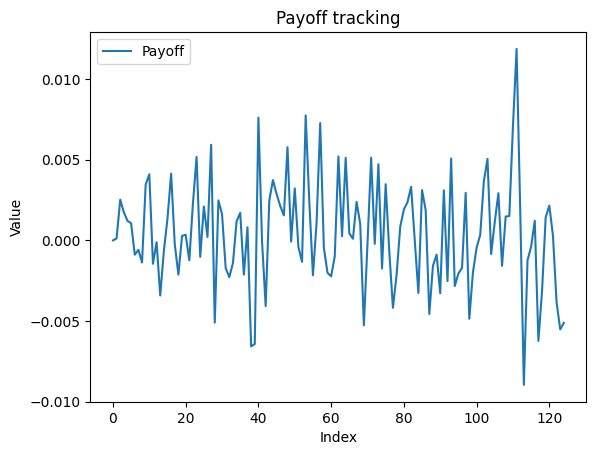

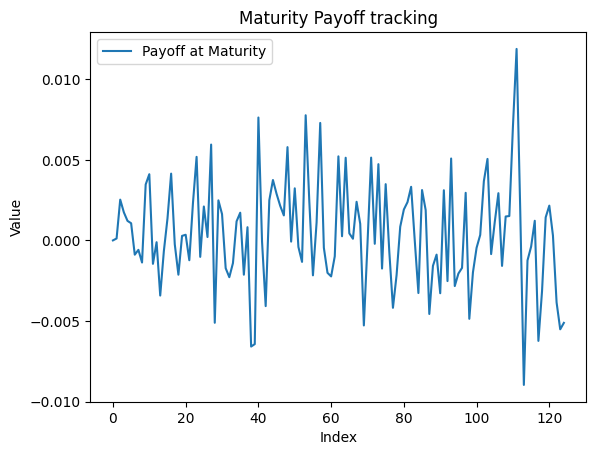

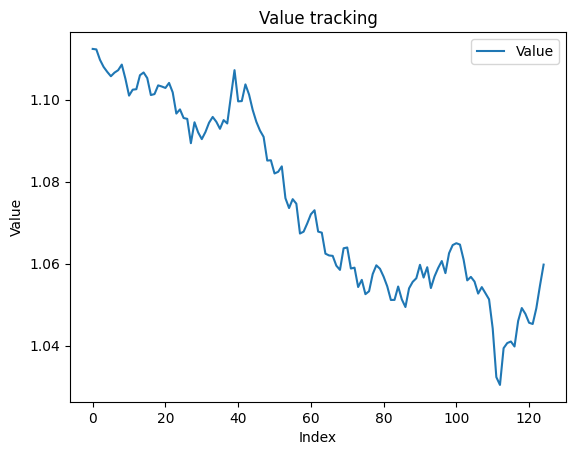

------------------------------2021-10-01------------------------------
Payoff: 0.06277463592936382


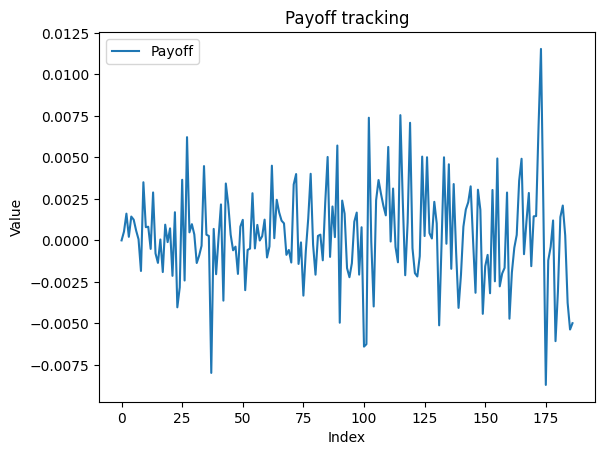

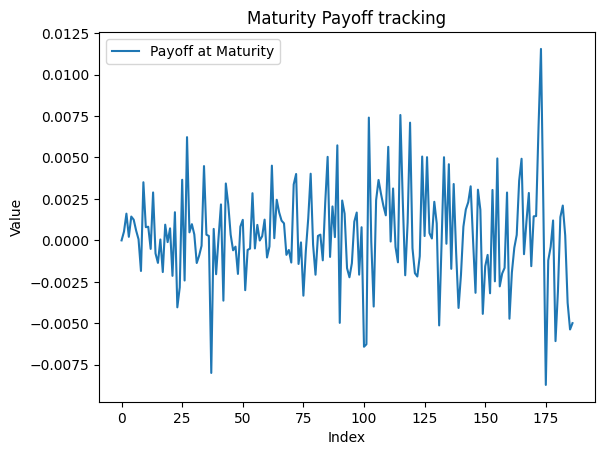

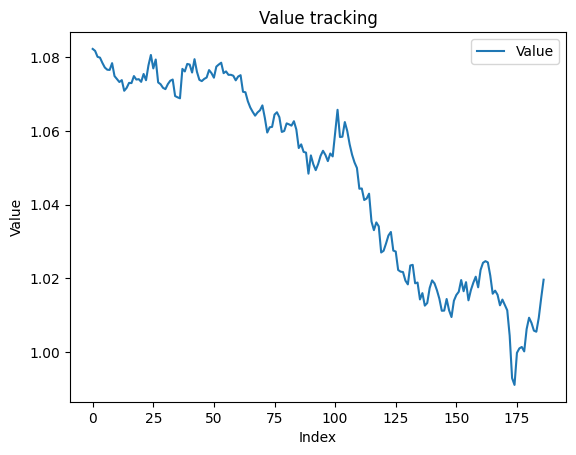

------------------------------2021-07-01------------------------------
Payoff: 0.05791347266441865


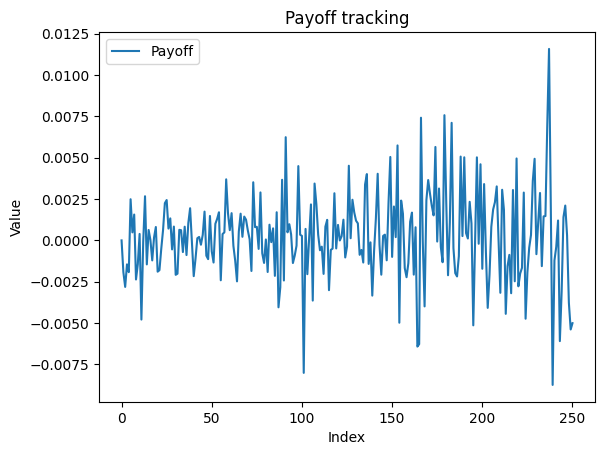

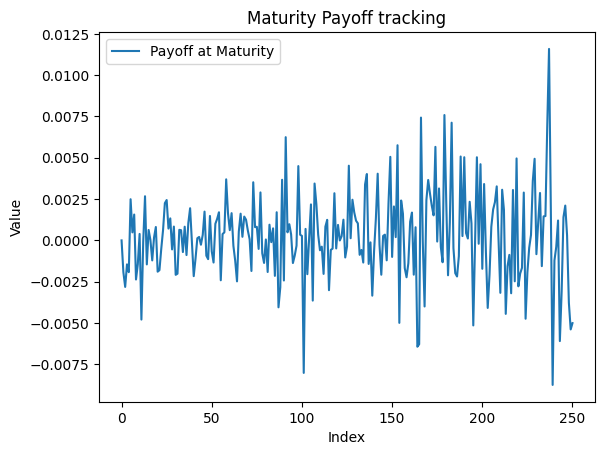

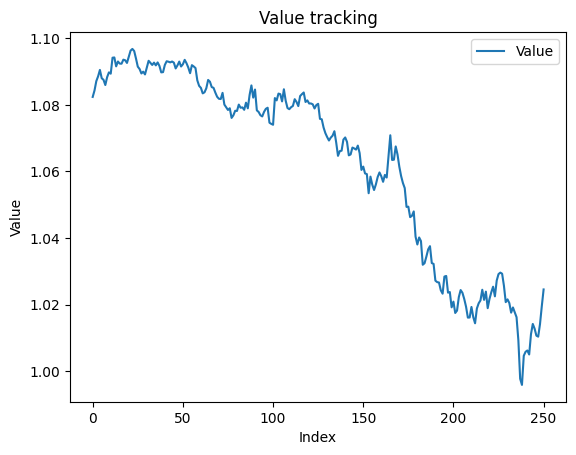

------------------------------2021-04-01------------------------------


KeyboardInterrupt: 

In [7]:
for date in ["2022-01-03", "2021-10-01", "2021-07-01", "2021-04-01"]:
    print(f"------------------------------{date}------------------------------")
    payoff, frame = swap_calculator(date)
    print("Payoff:", payoff)
    plt.plot(frame["Payoff"], label="Payoff")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Payoff tracking")
    plt.legend()
    plt.show()
    plt.plot(frame["Maturity Payoff"], label="Payoff at Maturity")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Maturity Payoff tracking")
    plt.legend()
    plt.show()
    plt.plot(frame["Value"], label="Value")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Value tracking")
    plt.legend()
    plt.show()

Comment on the payoff:

- The earlier the start, the less payoff at the maturity is
- This might be caused due to the more in votatility of the bonds at the earlier days.
